In [1]:
import splat
import wisps
import numpy as np
import matplotlib.pyplot as plt
from wisps import Annotator as an
from wisps import datasets
import pandas as pd
%matplotlib inline

#### Create a Training Set

My training set has wisps stuff and trash i.e things that I know are not bds

But not all of them, I'll just pick 4000 random objects to keep the proportion reasonable? It's a way of scaling my data idk
if this is the right way to go about it 


In [2]:
train_df=datasets['traing_set']

In [3]:
train_df['x']=train_df.spex_chi/train_df.line_chi

#### Choose relevant features

In [4]:
features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',  'spex_chi', 'snr2',
       'line_chi', 'f_test', 'x']
label='label'

#### Create a Prediction Set

In [5]:
data=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))
##only look at things with snr >3.0
#data=data[data['snr1']>3.0]

In [6]:
len(data)

110930

In [7]:
pred_df=wisps.Annotator.reformat_table(data[features]).applymap(np.float)

#### Apply logarithms to features that might be problematic features

In [8]:
prblm_feats=['line_chi', 'spex_chi', 'H_2O-2/J-Cont', 'H-cont/J-Cont', 'H_2O-1/J-Cont', 'H-cont/H_2O-1', 'snr2', 'x']
pred_df[prblm_feats]=pred_df[prblm_feats].applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
train_df[prblm_feats]=train_df[prblm_feats].applymap(np.float).applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)

#### Rename the class only make 2 classes: brown dwarf and not brown dwarf

In [9]:
def make_label_binary(labl):
    ##only two labels
    if labl >0.:
        return 1.
    else:
        return 0.

In [10]:
train_df['label']=train_df['label'].apply(make_label_binary)
#pred_df['label']=pred_df['label'].apply(make_label_binary)

#### Scale the data to avoid weird stuff 

In [11]:
train_df[features]=train_df[features].applymap(np.float).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
pred_df[features]=pred_df[features].applymap(np.float).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)

In [12]:
#scale the data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))
#train_set=train_df[features]

X_train, X_test, y_train, y_test = train_test_split(train_df[features].values, train_df[label].values, test_size=0.5,  random_state=123456) ###grammar  

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#scale the data set to predict for 
pred_set=scaler.transform(pred_df[features].replace(np.nan,  -999999.9).values)

#cleanup
X_train.shape

(4259, 15)

In [13]:
from sklearn.ensemble import RandomForestClassifier



def train_model(nestimators=100, random_state=123456):
    """
    trains the model given different parameters
    """
    rf = RandomForestClassifier(n_estimators=nestimators, oob_score=True, random_state=random_state)
    rf.fit(X_train, y_train)
    
    return rf

rf=train_model(nestimators=100, random_state=123456)

In [14]:
np.isnan(X_test).any(), np.isinf(X_test).any()

(False, False)

accuracy score 0.9474054942474759


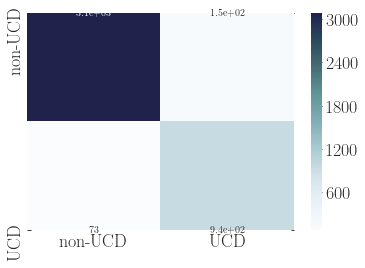

In [15]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
pred_labels = rf.predict(X_test)
model_accuracy = accuracy_score(y_test, pred_labels)

print ('accuracy score {}'.format(model_accuracy))
classes=['non-UCD', 'UCD']
cm = pd.DataFrame(confusion_matrix(y_test, pred_labels), 
                  columns=classes, index=classes)
sns.heatmap(cm, annot=True, cmap=wisps.MYCOLORMAP)
plt.savefig(wisps.OUTPUT_FIGURES+'/confusion_matrix.pdf')

In [16]:
from sklearn import preprocessing

#def plot_histogram(index):
#    fig, ax=plt.subplots()
#    #plt.xscale('log')
#    plt.yscale('log')
#    plt.hist(pred_set[:, index], bins=50)
    
#for index in np.arange(0, 13): plot_histogram(index)


In [17]:
labels=rf.predict(pred_set)

In [18]:
#np.where(labels==1.)

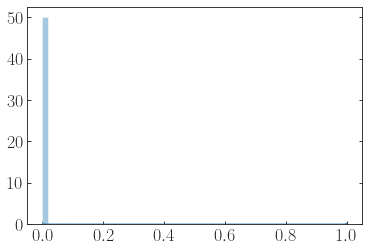

In [19]:
sns.distplot(labels)

In [20]:
len(data[labels==1]), len(data[labels==0])

(81, 110849)

In [21]:
sv_df=data[labels==1].reset_index(drop=True)

In [22]:
#sv_df

In [23]:
sv_df.to_pickle(wisps.LIBRARIES+'/labelled_by_rf.pkl')

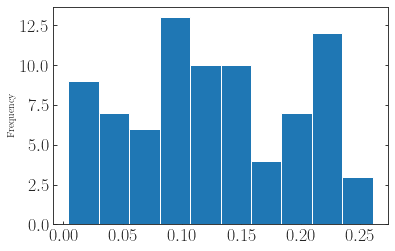

In [24]:
sv_df.f_test.plot(kind='hist')

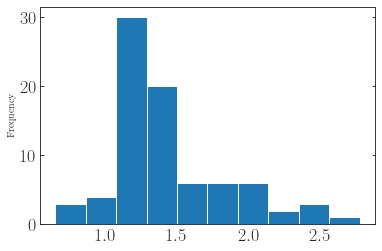

In [25]:
sv_df.snr2.apply(np.log10).plot(kind='hist')

In [26]:
tot=len(data[np.logical_and(labels==1, data.snr1>3. )])

In [27]:
tot

75

In [28]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf', key='with_indices')
cands['grism_id']=cands.grism_id.apply(lambda x: x.lower().strip())
tru_p=len(data[(data.grism_id.isin(cands.grism_id.values)) & (labels==1)])
tru_p

54

In [29]:
(tot-tru_p)/tot

0.28

In [30]:
import pickle

In [31]:
rf_dict=rf={'classifier': rf,
            'sclr':scaler,
            'feats':features}

In [32]:
#save the random forest
output_file=wisps.OUTPUT_FILES+'/random_forest_classifier.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(rf_dict,file)

In [1]:
import wisps.simulations as wispsim
import wisps.simulations.effective_numbers as eff
s=eff.simulation_outputs(recompute=True, hs=wispsim.HS)

100%|██████████| 7/7 [24:12<00:00, 207.56s/it]


{'saumon': {'f110': [array([18.57760095, 12.42267435, 19.76186879, ..., 12.1148962 ,
          15.74166916, 20.05754091]),
   array([18.11595552, 11.37638781, 19.68207168, ..., 12.37759343,
          15.32215157, 20.75453374]),
   array([18.44972835, 12.67923215, 19.26325611, ..., 12.59076316,
          15.47096737, 20.09998139]),
   array([18.35077184, 12.05990284, 18.78814352, ..., 13.1260049 ,
          15.60394248, 20.6371716 ]),
   array([17.75755136, 12.43823743, 19.97047197, ..., 13.34184552,
          14.99693656, 20.687094  ]),
   array([18.05847015, 12.37967658, 18.71245048, ..., 13.28495512,
          14.76769767, 20.31584392]),
   array([18.77608577, 12.01827485, 19.05482068, ..., 14.21273886,
          14.43893653, 20.60585463])],
  'f140': [array([18.20818569, 11.75126035, 18.83975816, ..., 12.09670875,
          15.02610406, 19.27498645]),
   array([18.35089296, 12.28858348, 19.23493626, ..., 12.03564891,
          14.59561752, 19.88770974]),
   array([17.51519179, 12.30